In [1]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [2]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)



In [3]:
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    #initialize sparse block matrices for effviciency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    #total Hamiltonian into smaller blocks->> better for memory
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        #lil_matrix for each block
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        #filling of papricas
        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    # combine withblock diagonal
    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)
    true_solution = np.array([1 if segment.truth else 0 for segment in segments])

    return A, b, segments, true_solution

#performance measurement
#process = psutil.Process()

#start_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
#start_time = time.time()

#A, b, segments, true_solution = generate_hamiltonian_optimized(event, params)
#end_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
#end_time = time.time()

#memory_used = end_memory - start_memory
#time_taken = end_time - start_time
#print(A.toarray())
#print(f"Memory used: {memory_used:.2f} MB")
#print(f"Time taken: {time_taken:.6f} seconds")
#print(true_solution)

In [4]:
import dimod
import psutil
import time
from scipy.sparse import csc_matrix

def qubosolver(A, b):


    #Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

#qubosolver(A, b)


In [10]:
def qubosolverQA(A, b):
    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-4d20b60b0faf5516868e16417928459ad087bd50'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    print(f"Solution: {sol_sample}")

    return sol_sample


In [9]:
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-4d20b60b0faf5516868e16417928459ad087bd50'
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix
from dimod import BinaryQuadraticModel

def qubosolverHr(A, b):
   
    # Keep A sparse
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Add the linear terms from vector b
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  # Only consider off-diagonal terms (interactions)
            bqm.add_interaction(i, j, A[i, j])

    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)


    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    return sol_sample
#qubosolverHr(A, b)

In [7]:
def qubosolverSA(A, b):
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.spatial.distance import hamming
from scipy.sparse import csc_matrix

def calculate_accuracy_metrics(true_solution, solver_solution):
    # Convert lists to arrays for element-wise operations
    true_solution = np.array(true_solution)
    solver_solution = np.array(solver_solution)
    percentage_similarity = np.mean(true_solution == solver_solution) * 100
    
    hamming_dist = np.sum(true_solution != solver_solution)
    smc = np.mean(true_solution == solver_solution)
    
    return percentage_similarity, hamming_dist, smc


def compare_qubo_solvers(N_PARTICLES_LIST, params):
    results = []
    
    for N_PARTICLES in N_PARTICLES_LIST:
        try:
            # Generate event and matrix
            event = generator.generate_event(N_PARTICLES)
            A, b, segments, true_solution = generate_hamiltonian_optimized(event, params)
            A = csc_matrix(A)
            b = np.array(b, dtype=np.int8)
        
            # Attempt each solver independently to save partial results in case of errors
            try:
                sol1 = np.array(qubosolverSA(A, b), dtype=np.int8)
                accuracy_1 = calculate_accuracy_metrics(true_solution, sol1)
                results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverSA", 
                                "Percentage_Similarity": accuracy_1[0],
                                "Hamming_Distance": accuracy_1[1], 
                                "Simple_Matching_Coefficient": accuracy_1[2]})
            except Exception as e:
                print(f"Error with qubosolverSA for N_PARTICLES={N_PARTICLES}: {e}")
            
            try:
                sol2 = np.array(qubosolverHr(A, b), dtype=np.int8)
                accuracy_2 = calculate_accuracy_metrics(true_solution, sol2)
                results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverHr", 
                                "Percentage_Similarity": accuracy_2[0],
                                "Hamming_Distance": accuracy_2[1], 
                                "Simple_Matching_Coefficient": accuracy_2[2]})
            except Exception as e:
                print(f"Error with qubosolverHr for N_PARTICLES={N_PARTICLES}: {e}")
                
            try:
                sol3 = np.array(qubosolverQA(A, b), dtype=np.int8)
                accuracy_3 = calculate_accuracy_metrics(true_solution, sol3)
                results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverQA", 
                                "Percentage_Similarity": accuracy_3[0],
                                "Hamming_Distance": accuracy_3[1], 
                                "Simple_Matching_Coefficient": accuracy_3[2]})
            except Exception as e:
                print(f"Error with qubosolverQA for N_PARTICLES={N_PARTICLES}: {e}")
        
        except MemoryError as mem_err:
            print(f"MemoryError encountered for N_PARTICLES={N_PARTICLES}: {mem_err}")
            continue
        
        except Exception as e:
            print(f"An error occurred while preparing for N_PARTICLES={N_PARTICLES}: {e}")
            continue
    
    # Convert results to DataFrame and return
    results_df = pd.DataFrame(results)
    # Save results as a CSV file to preserve progress
    results_df.to_csv("qubo_solver_resultsfinal.csv", index=False)
    return results_df

# Parameters and Particle List
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}
#N_PARTICLES_LIST = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80] 
N_PARTICLES_LIST = [2,4,6,8,10,12,14,16,18,20]

# Run the comparison function and save the results
results_df = compare_qubo_solvers(N_PARTICLES_LIST, params)
results_df.to_csv("qubo_solver_resultsFINALstuff.csv", index=False)


Solution:[1 0 0 1 1 0 0 1]
Solution: [1 0 0 1 1 0 0 1]
Solution: [1 0 0 1 1 0 0 1]
Solution:[1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
Solution: [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
Solution: [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the dataset in a dictionary format for easy DataFrame creation
#data = {
    #"N_PARTICLES": [5, 5, 5, 10, 10, 10, 15, 15, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 80],
    #"Solver": ["qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", 
               #"qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", 
               #"qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", 
               #"qubosolverSA", "qubosolverSA"],
    #"Percentage_Similarity": [100.0, 100.0, 100.0, 100.0, 100.0, 89.5, 100.0, 100.0, 93.0, 95.0, 
    #                          93.7778, 94.5556, 94.9688, 96.0, 96.1, 96.74, 96.5556, 97.1667, 97.0408, 97.375],
    #"Hamming_Distance": [0, 0, 0, 0, 0, 21, 0, 0, 56, 40, 112, 98, 161, 128, 195, 163, 248, 204, 290, 336],
    #"Simple_Matching_Coefficient": [1.0, 1.0, 1.0, 1.0, 1.0, 0.895, 1.0, 1.0, 0.93, 0.95, 
  #                                  0.9378, 0.9456, 0.9497, 0.96, 0.961, 0.9674, 0.9656, 0.9717, 0.9704, 0.97375]
#}

# Create the DataFrame
#results_df = pd.DataFrame(data)

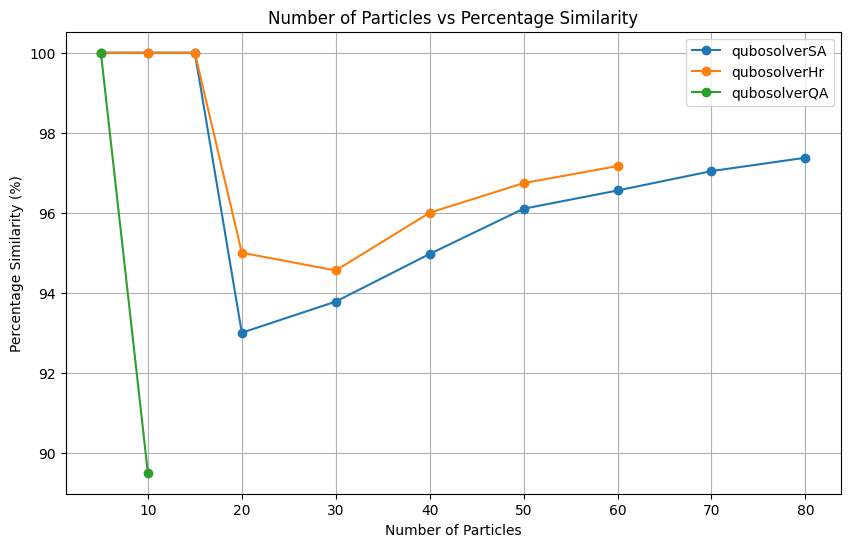

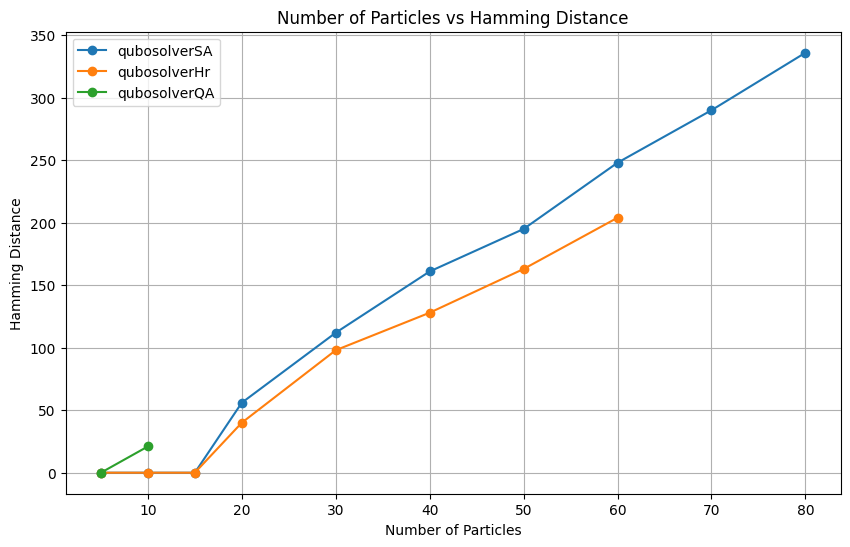

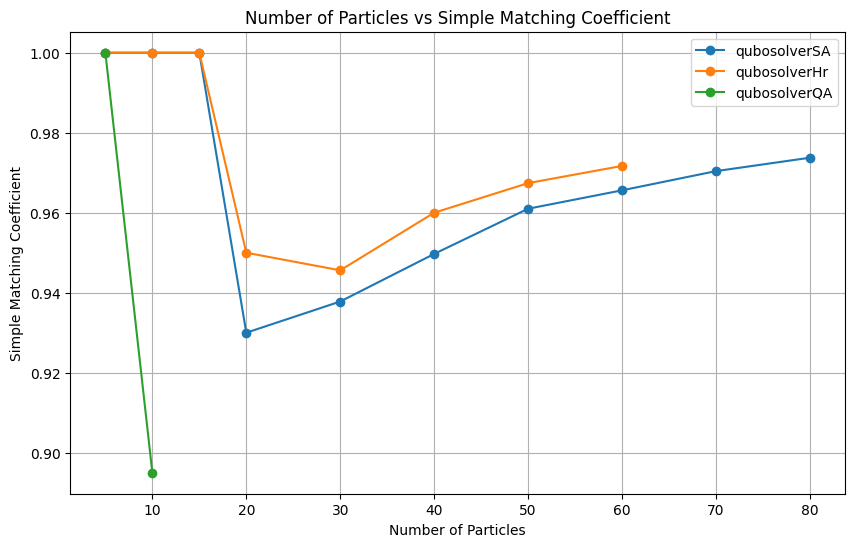

In [ ]:
solvers = results_df['Solver'].unique()  # Get unique solver names

# Plot 1: Number of Particles vs Percentage Similarity
plt.figure(figsize=(10, 6))
for solver in solvers:
    solver_data = results_df[results_df["Solver"] == solver]
    plt.plot(solver_data["N_PARTICLES"], solver_data["Percentage_Similarity"], label=solver, marker='o')
plt.title("Number of Particles vs Percentage Similarity")
plt.xlabel("Number of Particles")
plt.ylabel("Percentage Similarity (%)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Number of Particles vs Hamming Distance
plt.figure(figsize=(10, 6))
for solver in solvers:
    solver_data = results_df[results_df["Solver"] == solver]
    plt.plot(solver_data["N_PARTICLES"], solver_data["Hamming_Distance"], label=solver, marker='o')
plt.title("Number of Particles vs Hamming Distance")
plt.xlabel("Number of Particles")
plt.ylabel("Hamming Distance")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Number of Particles vs Simple Matching Coefficient
plt.figure(figsize=(10, 6))
for solver in solvers:
    solver_data = results_df[results_df["Solver"] == solver]
    plt.plot(solver_data["N_PARTICLES"], solver_data["Simple_Matching_Coefficient"], label=solver, marker='o')
plt.title("Number of Particles vs Simple Matching Coefficient")
plt.xlabel("Number of Particles")
plt.ylabel("Simple Matching Coefficient")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1]
Best Energy: -4.0
Brute Force Solution: [1 0 0 1 1 0 0 1]
